# Einfache lineare Regression und Residuenanalyse

Challenge: cml1/3Db Immobilienrechner <br/>
Team: Alexander Shanmugam, Si Ben Tran, Gabriel Torrez Gamez, Haris Alic <br/>
Aufgabe: 2.1 Einfache lineare Regression und Residuenanalyse

Verwende ein einfaches lineares Modell zur Vorhersage von `price_cleaned` mit dem Attribut `Space extracted` oder `Floor_space_merged` (es gibt einige, wo beide fehlen (um die 800, können ignoriert werden).

Entwickle das Modell in einem Notebook. Untersuche dabei ob die Annahmen eines linearen Modells erfüllt sind mit geeigneten Darstellungen. Wie können Variablen-Transformationen verwendet werden, um die Modellvoraussetzungen besser zu erfüllen und das Modell zu verbessern?

Rapportiere und diskutiere die erreichte Genauigkeit der Vorhersage mit mehreren sinnvollen Metriken und auf unabhängigen Testdaten.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf.

---

# Module importieren

Hier in diesem Abschnitt importieren wir die wichtigisten Module, die wir für die weitere Bearbeitung unserer simplen linearen Regressions Modelle benötigen, um die Vorhersage des Immobilienpreises zu erstellen.


In [70]:
# import Basic Data Science Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# scipy modules
from scipy.stats import norm
from scipy import stats

# Sklearn modules

# linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# model_selection
from sklearn.model_selection import train_test_split, cross_val_score

# metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


--- 

# Daten importieren

Hier in diesem Abschnitt importieren wir die Immobilien Daten, die uns Fernando zur Verfügung gestellt hat.

In [30]:
# load previous data (start of semester) 
#df = pd.read_csv("https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/immoscout_cleaned_lat_lon_fixed_v9.csv", usecols = ["Floor_space_merged", "Space extracted", "price_cleaned"])

# load new data
df = pd.read_parquet('https://github.com/Immobilienrechner-Challenge/data/blob/main/immo_data_202208_v2.parquet?raw=true', columns  = ["Floor_space_merged", "Space extracted", "price_cleaned"])

# display shape and head of DataFrame
print("Shape of DataFrame", df.shape)
display("DataFrame for simple linear Regression", df.head(5))

Shape of DataFrame (22481, 3)


'DataFrame for simple linear Regression'

,Floor_space_merged,Space extracted,price_cleaned
0,None,100.0,1150000.0
1,242 m²,156.0,1420000.0
2,None,NaN,720000.0
3,257 m²,154.0,1430000.0
4,None,142.0,995000.0


---

# Daten bearbeiten

Hier in diesem Abschnitt schauen wir uns die Spalten genauer an und entscheiden daraufhin, welche Feature wir fuer unser simples lineares Regressions Modell verwenden wollen.

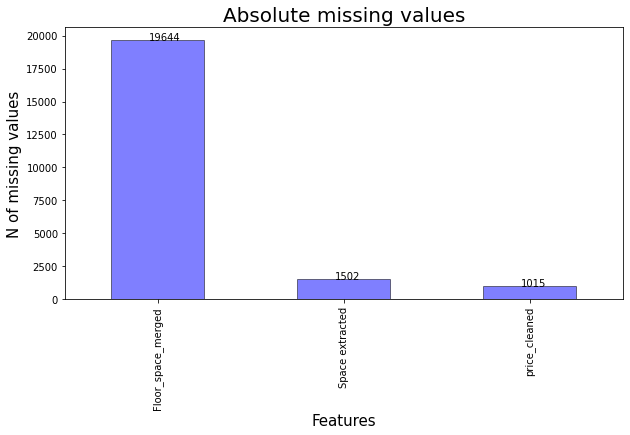

In [31]:
# Visualize missing values with barplot and number of missing value on top of each bar
def missing_values_barplot(df):
    """
    Visualize missing values with barplot and number of missing value on top of each bar
    Args:
        df (DataFrame): DataFrame with missing values
    """
    # Calculate number of missing values
    missing_values = df.isnull().sum().sort_values(ascending=False)
    # Concatenate number of missing values and percentage of missing values
    missing_values = pd.concat([missing_values], axis=1, keys=['Number of missing values'])
    # Plot barplot
    missing_values.plot(kind='bar', figsize=(10, 5), color = "blue", alpha = 0.5, linewidth = 1, edgecolor = "black")
    # Add number of missing values on top of each bar
    for i in range(len(missing_values)):
        plt.text(x = i-0.05 , y = missing_values['Number of missing values'][i], s = missing_values['Number of missing values'][i], size = 10)
    plt.title('Absolute missing values', fontsize=20)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('N of missing values', fontsize=15)
    plt.legend().remove()
    plt.show()

# Visualize missing values with barplot and number of missing value on top of each bar
missing_values_barplot(df)

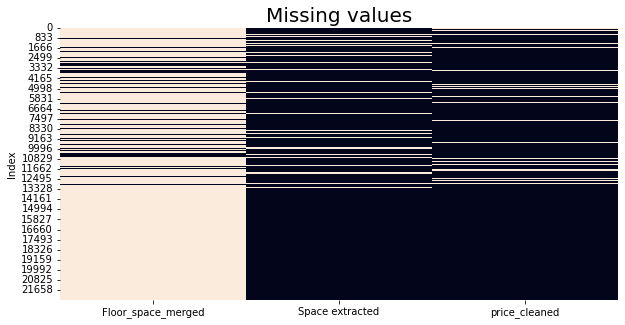

In [32]:
# Create heatmap isna map
def heatmap_isna(df):
    """
    Create heatmap isna map
    Args:
        df (DataFrame): DataFrame with missing values
    """
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.isnull(), cbar=False)
    plt.ylabel('Index')
    plt.title('Missing values', fontsize=20)
    plt.show()

# Create heatmap isna map
heatmap_isna(df)

Wir entscheiden uns fuer das Feature space_extracted und als Target price_cleaned.  
Floor_space_merged wird fuer das lineare Regressionsmodell nicht verwendet, da ueber 10000 Fehlende Werte im Feature vorhanden sind. Dies erkennen wir einerseits im Barplot und andererseits in der Heatmap Visualisierung. 

---

# Verteilungen

Wir plotten die Verteilung von space_extracted und price_cleaned um zu sehen, wie die Verteilung der Daten vorliegt.

In [33]:
# drop rows with missing values
df = df[["price_cleaned", "Space extracted"]]

# drop rows with missing values
df_clean = df.dropna()

# display df_clean shape and head
print("Shape of DataFrame", df_clean.shape)
display("DataFrame selected", df_clean.head(5))

Shape of DataFrame (20165, 2)


'DataFrame selected'

,price_cleaned,Space extracted
0,1150000.0,100.0
1,1420000.0,156.0
3,1430000.0,154.0
4,995000.0,142.0
5,2160000.0,190.0


In [34]:
# Show Distribution of space_extracted and price_cleaned using histplot
def show_distribution(df, features, binsize = 100):
    """
    Show Distribution of space_extracted and price_cleaned
    Args:
        df (DataFrame): DataFrame with missing values
        feature (list): Features to show distribution
        binsize (int): Number of bins for histplot - default = 100
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    # Plot histplot for space_extracted
    sns.histplot(df[features[0]], ax=ax[0], kde=True, bins = binsize)
    # Plot histplot for price_cleaned
    sns.histplot(df[features[1]], ax=ax[1], kde=True, bins = binsize)

    ax[0].set_title('Distribution of ' + features[0], fontsize=20)
    ax[0].set_xlabel(features[0], fontsize=15)
    ax[0].lines[0].set_color('crimson')    
   
    ax[1].set_title('Distribution of ' + features[1], fontsize=20)
    ax[1].set_xlabel(features[1], fontsize=15)
    ax[1].lines[0].set_color("crimson")
    plt.show()


## Verteilung von space_extracted & price_cleaned

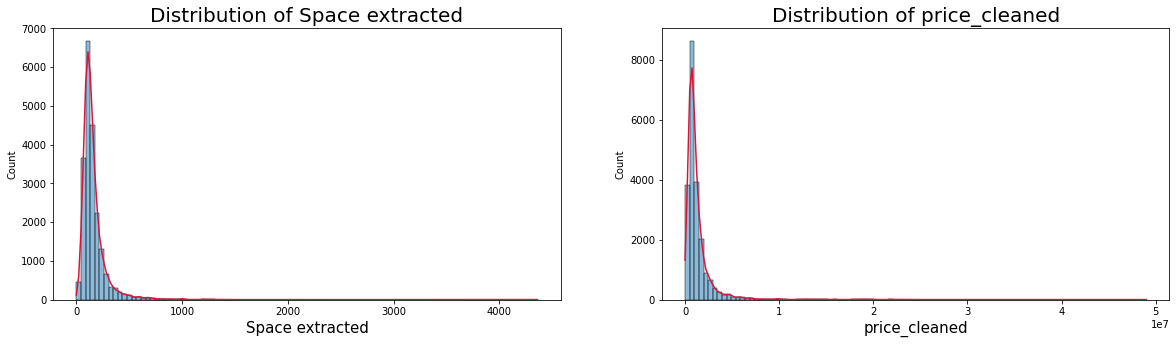

In [35]:
# Show Distribution of space_extracted and price_cleaned
show_distribution(df, features = ['Space extracted', 'price_cleaned'])

Wir erkennen in beiden Verteilungsplot, dass space_extraced und price_cleaned nicht normalverteilt sind. Es sieht aus, wie eine Rechtsschiefe Verteilung. Es gibt einige Werte bei Space_extraced und price_cleaned die sehr hoch sind und somit die Verteilung beeinflussen.
Mittels geeigneter Transformationen durch sqrt oder log, koennen wir die Verteilung der Daten veraendern. Der Grund, warum wir die Transformationen durchfuehren basiert auf den Bedinungen der Residuenanalyse, die im naechsten Abschnitt behandelt wird.


## Verteilung von sqrt_space_extracted & sqrt_price_cleaned

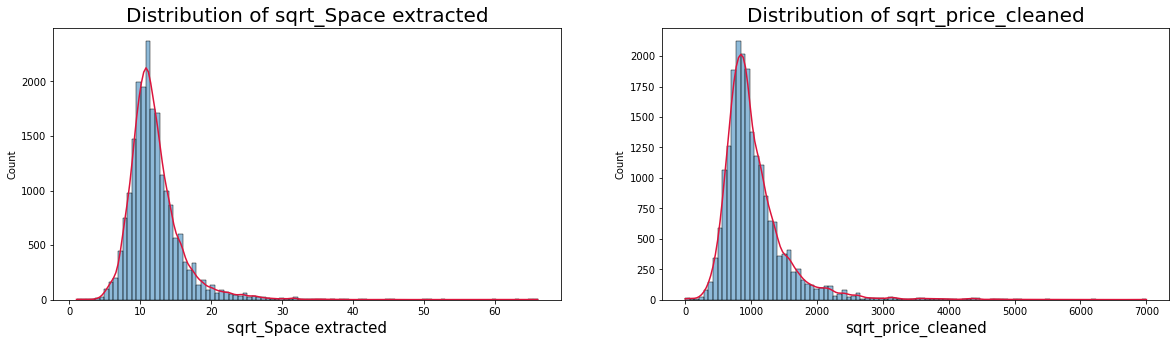

In [36]:
# copy DataFrame
df_clean_sqrt = df_clean.copy()

# np.sqrt space_extracted and price_cleaned
df_clean_sqrt['sqrt_Space extracted'] = np.sqrt(df_clean_sqrt['Space extracted'])
df_clean_sqrt['sqrt_price_cleaned'] = np.sqrt(df_clean_sqrt['price_cleaned'])

# show distribution
show_distribution(df_clean_sqrt, ['sqrt_Space extracted', 'sqrt_price_cleaned'])

Durch die Wurzel Transformation erhalten wir fuer spaec_extracted und price_cleaned eine annaehrend normalverteilte Verteilung.

## Verteilung von log_space_extracted & log_price_cleaned

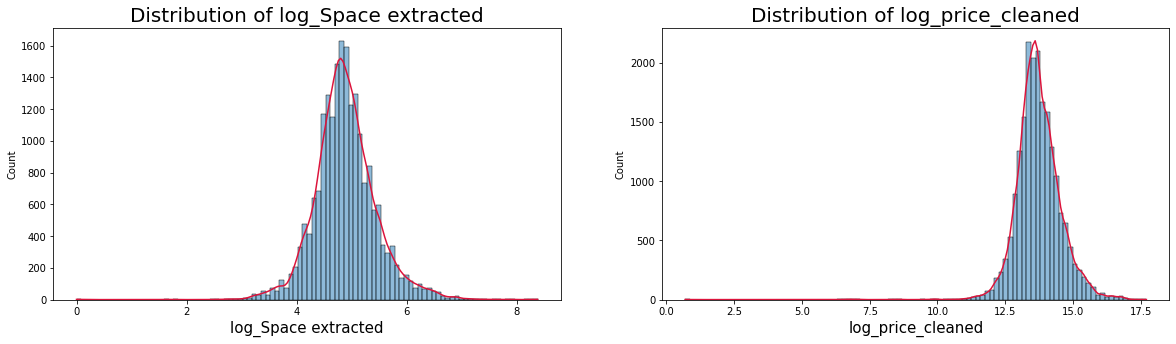

In [37]:
# copy DataFrame
df_clean_log = df_clean.copy()

# np.log space_extracted and price_cleaned
df_clean_log['log_Space extracted'] = np.log(df_clean_log['Space extracted'])
df_clean_log['log_price_cleaned'] = np.log(df_clean_log['price_cleaned'])

# show distribution
show_distribution(df_clean_log, ['log_Space extracted', 'log_price_cleaned'])

Analog zur Wurzel Transformation, erhalten wir durch den log Transformation eine annaehrend normalverteilte Verteilung fuer space_extracted und price_cleaned.

---

# Funktion Lineare Regression mit Residuenanalyse

In [38]:
# create x and y variabels for regression
space_extracted = df_clean['Space extracted'].values.reshape(-1, 1)
price_cleaned = df_clean['price_cleaned'].values.reshape(-1, 1)

In [40]:
# create a function for sklearn linear Regression model with cross validation
def linear_regression_model(x, y, test_size=0.2, random_state=42, x_transform = None, y_transform = None):
      """
      Create a function for sklearn linear Regression model with cross validation
      Args:
            x (array): x variable for regression
            y (array): y variable for regression
            test_size (float): test size for cross validation
            random_state (int): random state for cross validation
            x_transform (str): transform x variable based on np.sqrt or np.log
            y_transform (str): transform y variable based on np.sqrt or np.log
      """
      # Labeling and transform x and y variable
      if x_transform == 'sqrt':
            x = np.sqrt(x)
            x_label = 'sqrt_Space extracted'
      elif x_transform == 'log':
            x = np.log(x)
            x_label = 'log_Space extracted'
      else:
            x_label = 'Space extracted'
      
      if y_transform == 'sqrt':
            y = np.sqrt(y)
            y_label = 'sqrt_price_cleaned'
      elif y_transform == 'log':
            y = np.log(y)
            y_label = 'log_price_cleaned'
      else:
            y_label = 'price_cleaned'
      
      title_scatter = x_label + ' vs. ' + y_label
      title_y_yhat =  y_label + ' True vs ' + y_label + ' Predicted'

      # Split data into training and testing sets
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

      # Create linear regression object 
      regr = LinearRegression()

      # Train the model using the training sets
      regr.fit(x_train, y_train)

      # Make predictions using the testing set
      y_pred = regr.predict(x_test)

      # transform y_pred and y_test to original scale
      if y_transform == 'sqrt':
            y_pred_metric = y_pred**2
            y_test_metric = y_test**2
      elif y_transform == 'log':
            y_pred_metric = np.exp(y_pred)
            y_test_metric = np.exp(y_test)
      else:
            y_pred_metric = y_pred
            y_test_metric = y_test            

      # the mean absolute error
      mae = np.round(mean_absolute_error(y_test_metric, y_pred_metric), 3)

      # the mean absolute percentage error
      mape = np.round(mean_absolute_percentage_error(y_test_metric, y_pred_metric), 3)
      
      # the R2 score
      r2 = np.round(r2_score(y_test_metric, y_pred_metric), 3)

      # Scatte plot and regression Trendline
      fig, ax = plt.subplots(1, 2, figsize=(20, 5))
      # Scatter plot for x and y
      ax[0].scatter(x_test, y_test, color='blue', alpha = 0.2)
      ax[0].plot(x_test, y_pred, color='red', alpha = 0.5, linestyle='--')
      ax[0].set_title(title_scatter, fontsize=20, y = 1.05)
      ax[0].set_xlabel(x_label, fontsize=15)
      ax[0].set_ylabel(y_label, fontsize=15)

      # Plot y_test and y_pred
      ax[1].scatter(y_test, y_pred, color='blue', alpha = 0.2)
      ax[1].plot(y_test, y_test, color='red', alpha = 0.5, linestyle='--')
      ax[1].set_title(title_y_yhat, fontsize=20, y = 1.05)
      ax[1].set_xlabel('y_true values', fontsize=15)
      ax[1].set_ylabel('y_hat predicted values', fontsize=15)   

      # add fig.text
      fig.text(0.1, -0.1, f'MAE: {mae} | MAPE: {mape} | R2: {r2}', ha='left', va="bottom" ,fontsize=10)
      plt.show()

      # Residuenanalyse
      # For the residueanalyse we are checking three conditions:
      # The error shouldn’t be dependent
      # The expected value should be around 0
      # The residuals should follow normal distribution
      
      # residual plot
      residuals = y_test - y_pred

      # standardize residuals
      standardized_residuals = (residuals - residuals.mean()) / residuals.std()

      # Residual plot
      fig, ax = plt.subplots(1, 2, figsize=(20, 5))
      # Residual Scatterplot
      ax[0].scatter(y_pred, standardized_residuals, color='blue', alpha = 0.2)
      # add horizontal line at 0
      ax[0].axhline(y=0, color='red', linestyle='--', alpha = 0.5)
      ax[0].set_title('Residual Plot', fontsize=20, y = 1.05)
      ax[0].set_xlabel('Predicted Values', fontsize=15)
      ax[0].set_ylabel('Standardized Residuals', fontsize=15)

      # distribution plot 
      sns.histplot(standardized_residuals, ax=ax[1], kde=True)
      ax[1].set_title('Distribution Plot', fontsize=20, y = 1.05)
      ax[1].set_xlabel('Standardized Residuals', fontsize=15)
      ax[1].set_ylabel('Frequency', fontsize=15)
      ax[1].axvline(x=0, color='red', alpha = 0.5, linestyle='--')
      plt.show()

---
# Modell 1 - Linear Regression mit space extracted & price_cleaned

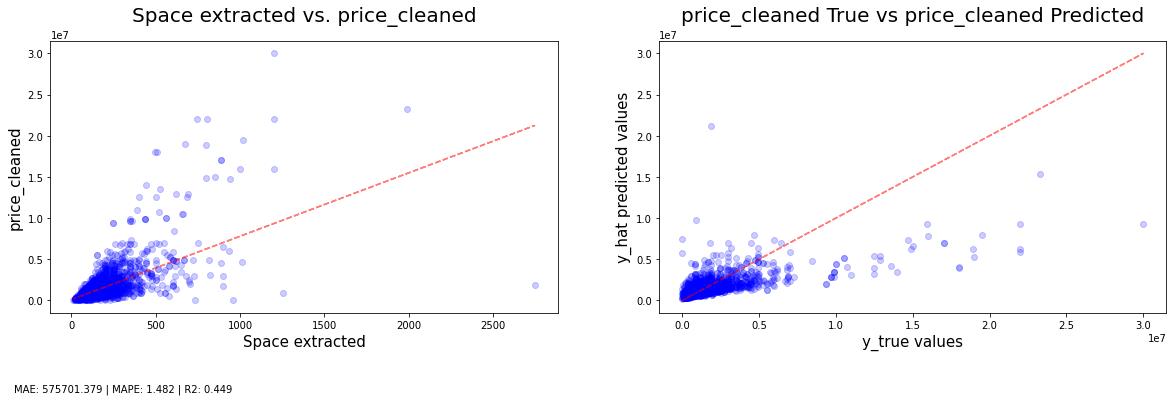

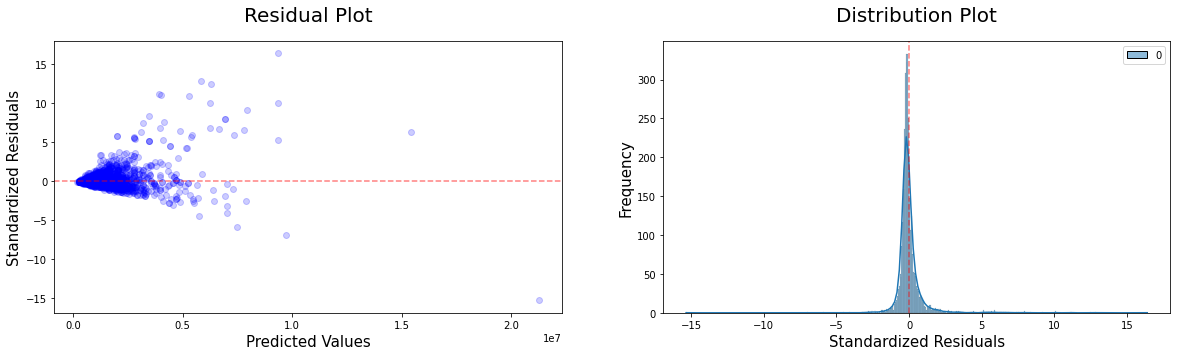

In [41]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "None", y_transform = "None")

## Modell 1 - Resultate und Interpretation

Ein Lineares Regressionsmodell ohne Transformation der Daten liefert uns folgende Ergebenisse:

- MAE   : 575701
- MAPE  : 1.482
- R2    : 0.449

Wir erkennen im Streudiagramm, das space_extracted und price_cleaned nicht linear korrelieren. Ein Indiz dafuer gibt uns auch der R2.

Aufgrund der Residuenanalyse erkennen wir, dass die Annahmen des linearen Regressionsmodells nicht erfuellt sind. Die Residuen sind nicht unabhaengig voneinander. 

Durch Transformationen von der x-Achse oder y-Achse koennen wir ueberpruefen, ob die Annahmen des linearen Regressionsmodells erfuellt werden. Dies geschieht im naechsten Abschnitt

---
# Modell 2 - Linear Regression mit sqrt_space_extracted & price_cleaned

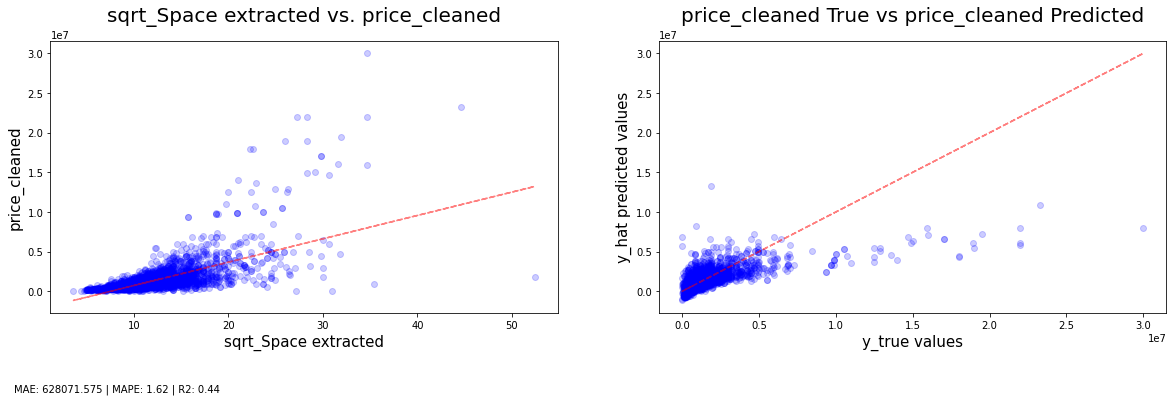

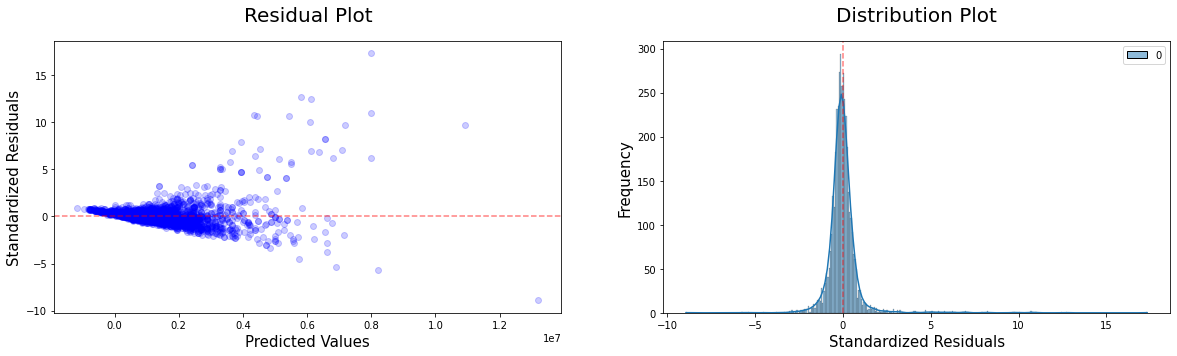

In [42]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "sqrt", y_transform = "None")

## Modell 2 - Resultate und Interpretation

Ein Lineares Regressionsmodell mittels sqrt Transformation von space_extracted liefert uns folgende Ergebenisse:

- MAE   : 628072
- MAPE  : 1.62
- R2    : 0.44

Die Transformation mittels sqrt von space_extraced ergibt uns per se kein besseres Modell verglichen zum ersten Modell. 

Aufgrund der Residuenanalyse erkennen wir, dass die Annahmen des linearen Regressionsmodells nicht erfuellt sind. Die Residuen sind nicht unabhaengig voneinander, sondern folgen einer Kegelform Muster.

Im naechsten Abschnitt nehmen wir die Transformation von price_cleaned vor und schauen uns an, ob sich das Modell verbessert.

---
# Modell 3 - Linear Regression mit pace_extracted & sqrt_price_cleaned

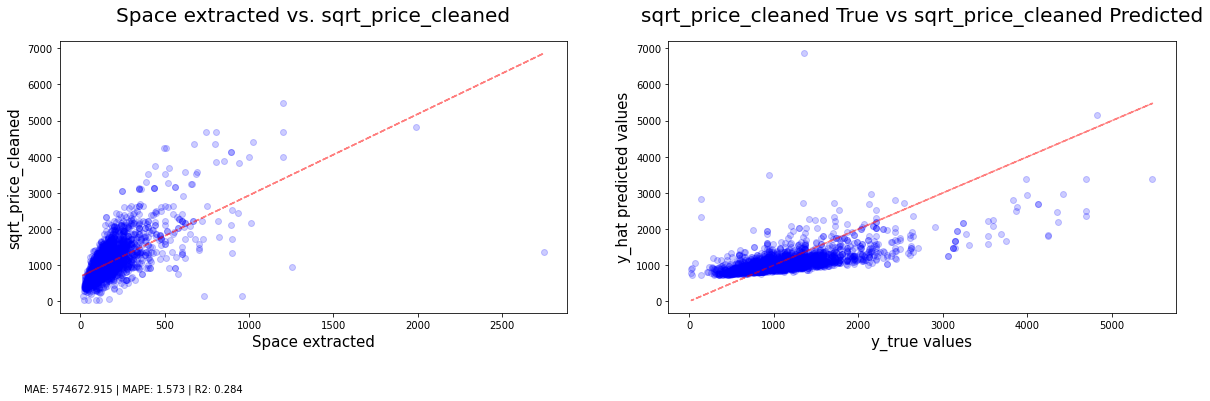

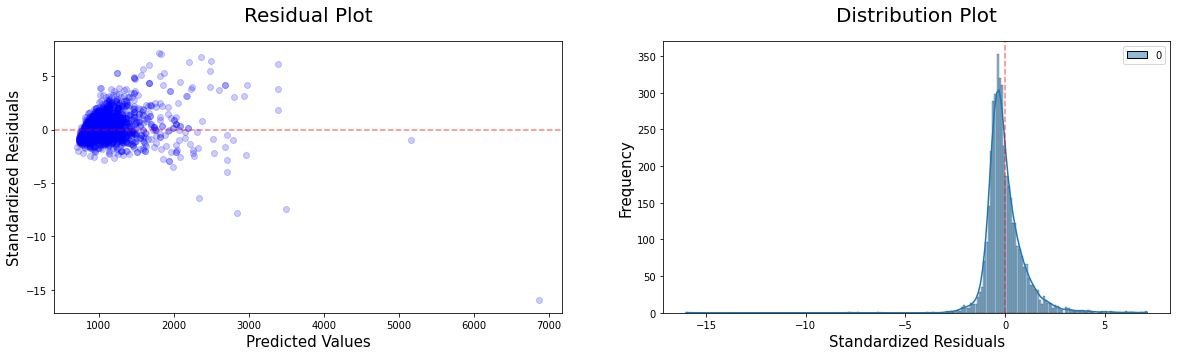

In [43]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "None", y_transform = "sqrt")

## Modell 3 - Resultate und Interpretation

Ein Lineares Regressionsmodell mittels Transformation von price_cleaned liefert uns folgende Ergebenisse:

- MAE   : 574673
- MAPE  : 1.573
- R2    : 0.284

Wir erkennen, durch die Transformation der Targetvariabel price_cleaned wird das Modell nicht besser sondern schlechter verglichern zu den ersten beiden Modellen.

Ein nun interessantes Modell ist das Modell 4, welches wir dann beide Achsen mittels sqrt transformieren werden, um zu sehen, ob sich das Modell verbessert und die Bedingungen der Residuenanalyse erfuellt.


---
# Modell 4 - Lineare Regression mit sqrt_space_extracted & sqrt_price_cleaned

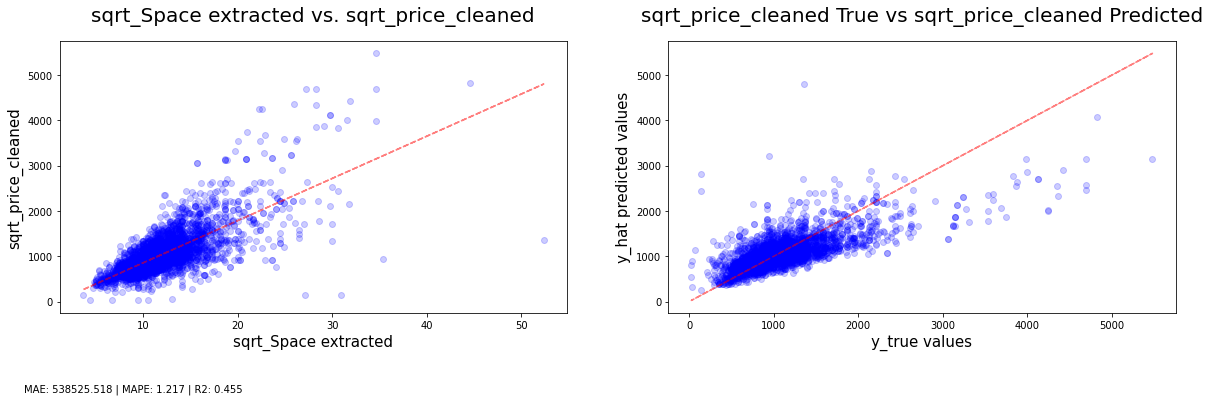

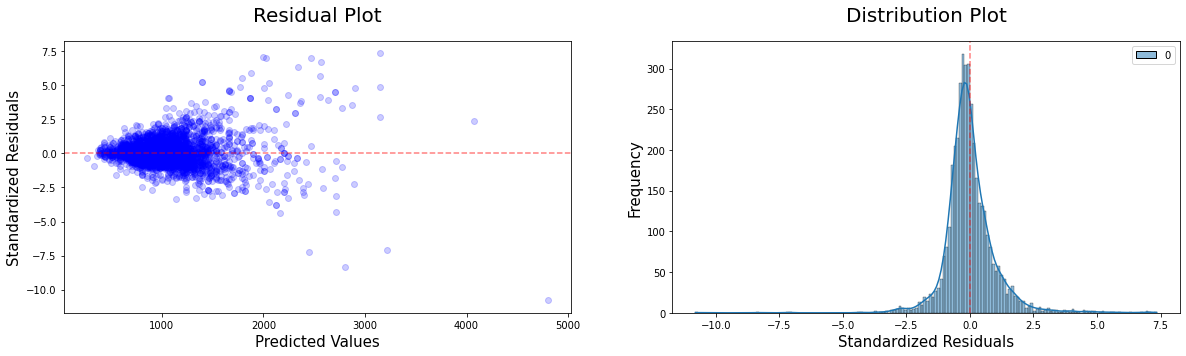

In [44]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "sqrt", y_transform = "sqrt")

## Modell 4 - Resultate und Interpretation

Ein Lineares Regressionsmodell mittels Wurzeltransformation von space_extraced und price_cleaned liefert uns folgende Ergebenisse:

- MAE   : 538526
- MAPE  : 1.217
- R2    : 0.455

Durch die Wurzeltransformationen beider Achsen verbessert sich das Modell einwenig. Dies erkennen wir am MAPE und am R^2.
Der MAPE ist tiefer und der R^2 hoeher. 

Aufgrund der Residuenanalyse erkennen wir, dass die Annahmen des linearen Regressionsmodells nicht ganz erfuellt werden. Die Residuen sind annaehrend unabhaengig voneinander, folgen jedoch leicht einem Kegelmuster. Dafuer haben die Residuen einen Erwartungswert von 0 und sind Normalverteilt.

---
# Modell 5 - Lineare Regression mit log_space_extracted & price_cleaned

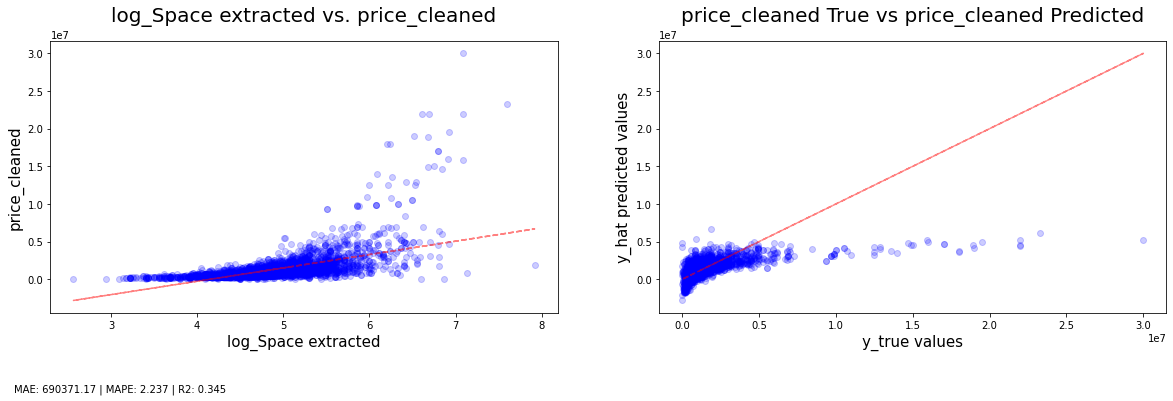

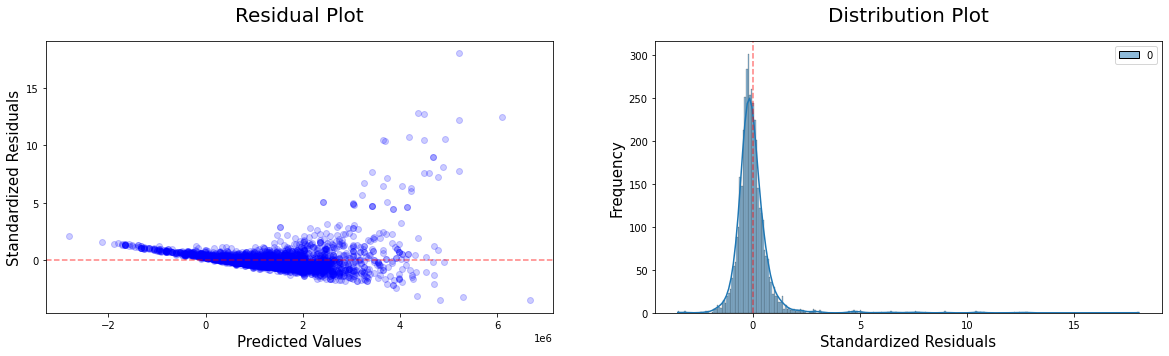

In [45]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "log", y_transform = "None")

## Modell 5 - Resultate und Interpretation

Ein Lineares Regressionsmodell mittels Log Transformation von space_extraced liefert uns folgende Ergebenisse:

- MAE   : 690371
- MAPE  : 2.237
- R2    : 0.345

Durch die Logarithmische Transformation von space_extraced wird das Modell verglichen zur sqrt Transformation beider Achsen schlechter. Dies ist deutlich am MAPE erkennbar, da diese nun deutlich hoeher ist und der R^2 tiefer wurde. 

Aufgrund der Residuenanalyse erkennen wir, dass die Annahmen des linearen Regressionsmodells nicht erfuellt werden. Die Residuen sind nicht unabhaengig voneinander. Der Erwartungswert und die Verteilung der Residuen sind dafuer in Ordnung. 

Vollstaendigkeitshalber transformieren wir in naechsten Abschnitt nur die Targetvariabel price_cleaned mittels log Transformation.

---

# Modell 6 - Lineare Regression mit space_extracted & log_price_cleaned

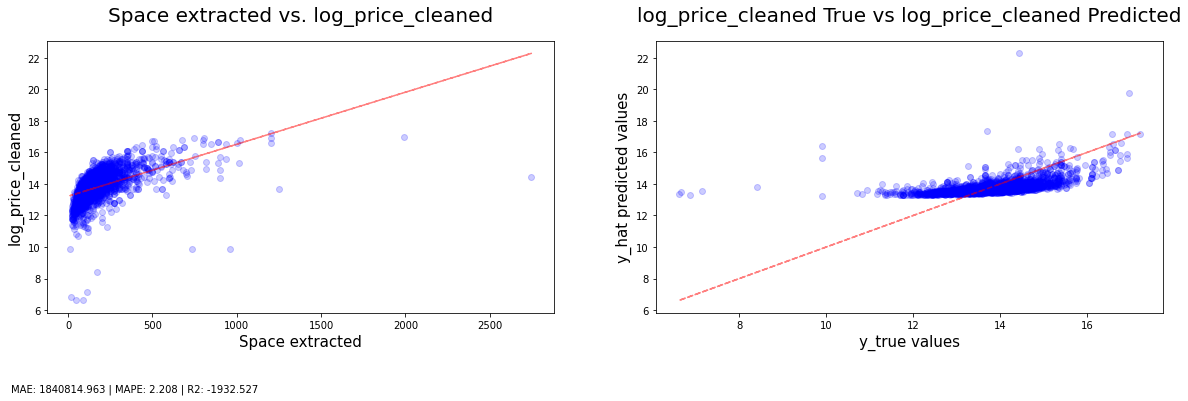

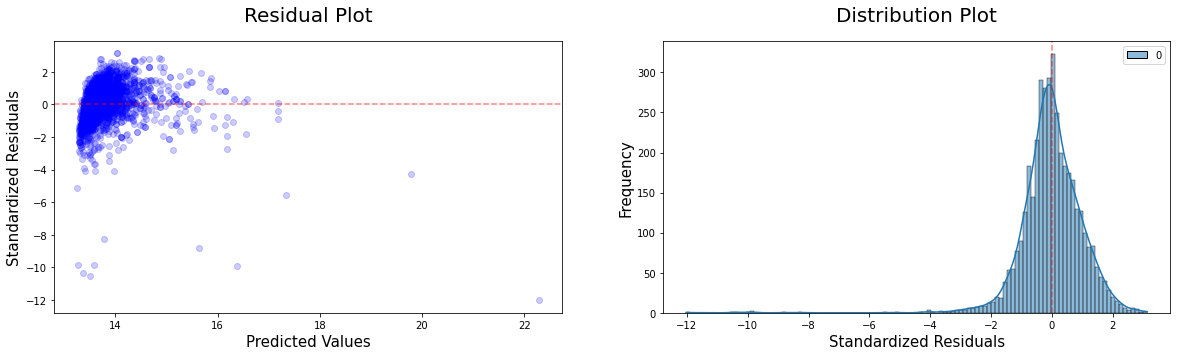

In [46]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "None", y_transform = "log")

## Modell 6 - Resultate und Interpretation

Ein Lineares Regressionsmodell mittels Log Transformation von price_cleaned liefert uns folgende Ergebenisse:

- MAE   : 1840815
- MAPE  : 2.208
- R2    : -1933

Durch die logarithmische Transformation von nur price_cleaned wurde das Modell noch schlechter. Analog ist dies bei der Wurzeltransformation von nur price_cleaned zu beobachten. Dieses Modell ist somit nicht geeignet, da der R^2 Score einen negativen Wert hat und somit das Lineare Modell nicht sinnvoll ist. 

Im naechsten Abschnitt befassen wir uns mit der logarithmischen Transformation beider Achsen, sprich von space_extraced und price_cleaned und schauen uns an, ob sich das Modell verbessert. Aufgrund der sqrt Transformation gehen wir davon aus, dass sich das Modell verbessern muss. 

---
# Modell 7 - Lineare Regression mit log_space_extracted & log_price_cleaned

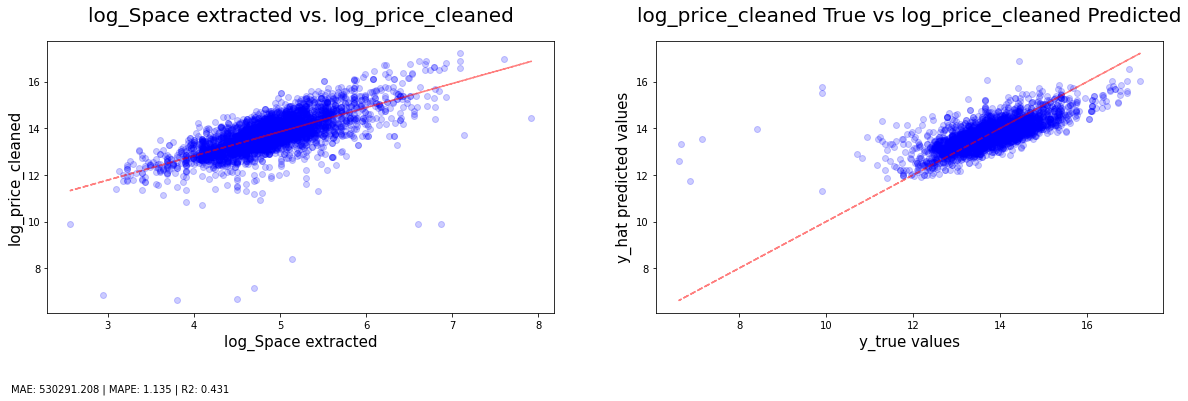

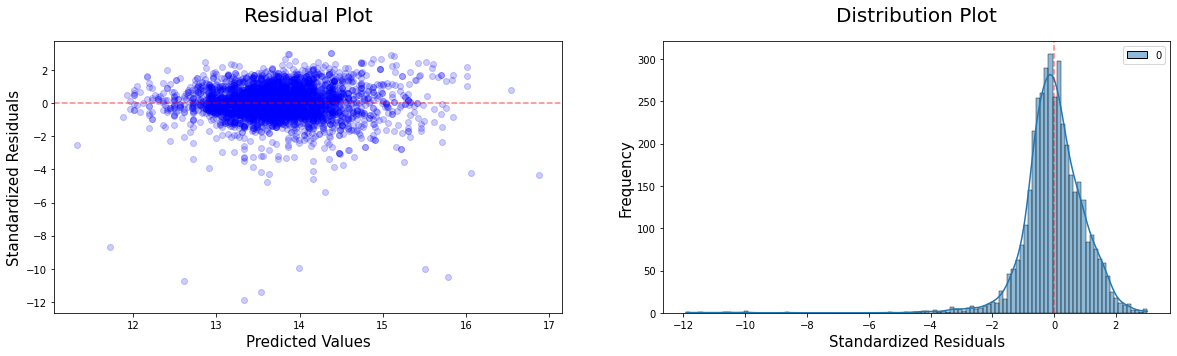

In [47]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "log", y_transform = "log")

## Modell 7 - Resultate und Interpretation

Ein Lineares Regressionsmodell mittels Log Transformation von space_extraced und price_cleaned liefert uns folgende Ergebenisse:

- MAE   : 530291
- MAPE  : 1.135
- R2    : 0.431

wie erwartet hat sich das Modell durch die Transformationen von beiden Achsen deutlich verbessert. Wir erkennen, das der MAPE tiefer ist als ohne Transformation. Auch erkennen wir im Streudiagramm einige Ausreisser, die wahrscheinlich den grossteil von MAPE beeinflussen. Die Residuen sind unabhaengig voneinander und folgen einer Normalverteilung und haben einen Erwartungswert von 0. 

Verglichen zur Wurzeltransformation ist es hier deutlich erkennbarer, dass die Residuen unabahengiger voneinander sind und somit die Annahmen des linearen Regressionsmodells besser erfuellen. 

Aus diesem Grund werden wir nun uns weiter mit dem Modell 7 befassen und versuchen, dieses Modell weiter zu optimieren bzw. die Metriken zu verbessern.

---

# Ausreisser entfernen

Damit wir den MAPE weiter senken koennen, entfernen wir nun die Ausreisser, die wir im Streudiagramm erkennen konnten. Wir entfernen die Ausreisser, indem wir die Datenpunkte entfernen, die bei der Logarithmischen Transformation einen groesseren oder kleineren Wert als 3 Sigma haben. 

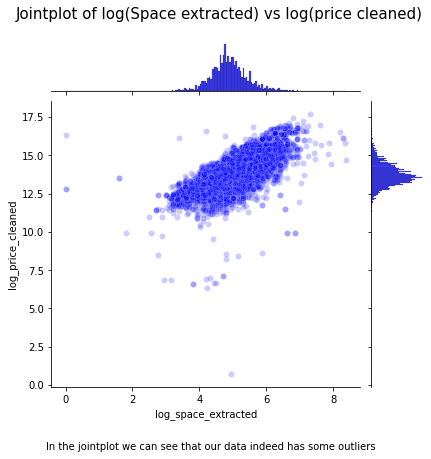

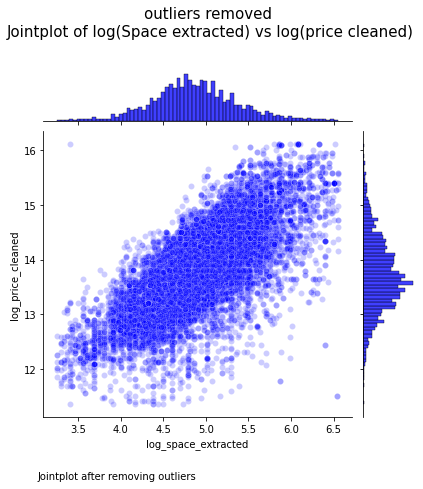

We removed 321 outliers in our dataset
(19844, 2)


,Space_extracted,price_cleaned
0,1150000.0,100.0
1,1420000.0,156.0
2,1430000.0,154.0
3,995000.0,142.0
4,2160000.0,190.0


In [68]:
# create x_log and y_log dataframe
log_space_extracted = np.log(space_extracted)
log_price_cleaned = np.log(price_cleaned)
df_log_outliers = pd.DataFrame({'log_price_cleaned': log_price_cleaned.flatten(), 'log_space_extracted': log_space_extracted.flatten()})

# save the n of observations in df_log_outliers
n_outliers = df_log_outliers.shape[0]

# create jointplot
sns.jointplot(x='log_space_extracted', y='log_price_cleaned', data=df_log_outliers, color='blue', alpha = 0.2)
plt.subplots_adjust(top=0.9)
plt.suptitle('Jointplot of log(Space extracted) vs log(price cleaned)', fontsize=15)
plt.xlabel('log(Space extracted)', fontsize=15)
plt.ylabel('log(price_cleaned)', fontsize=15)
plt.figtext(0.1, -0.05, "In the jointplot we can see that our data indeed has some outliers", ha='left', va="bottom" ,fontsize=10)
plt.show() 

# remove every outlier with zscore > 3
df_log = df_log_outliers[(np.abs(stats.zscore(df_log_outliers)) < 3).all(axis=1)]

# save the n of observations in df_log
n_outliers_removed = df_log.shape[0]

# create jointplot
sns.jointplot(x='log_space_extracted', y='log_price_cleaned', data=df_log, color='blue', alpha = 0.2)
plt.subplots_adjust(top=0.9)
plt.suptitle('outliers removed \nJointplot of log(Space extracted) vs log(price cleaned)', fontsize=15, y = 1.05)
plt.xlabel('log(Space extracted)', fontsize=15)
plt.ylabel('log(price_cleaned)', fontsize=15)
plt.figtext(0.1, -0.05, "Jointplot after removing outliers", ha='left', va="bottom" ,fontsize=10)
plt.show()

# calculate the n of removed outliers
n_removed_outliers = n_outliers - n_outliers_removed

# print the n of removed outliers
print(f'We removed {n_removed_outliers} outliers in our dataset')

# both space_extraced and price_cleaned are log transformed, to use our function correctly we need to transform them back
df_removed_outliers = np.exp(df_log)

# rename columns
df_removed_outliers.columns = ['Space_extracted', 'price_cleaned']

# display shape and head of df_space_extracted_price_cleaned
print(df_removed_outliers.shape)
display(df_removed_outliers.head())

# create x and y variabels for regression
space_extracted_outliers_removed = df_removed_outliers['Space_extracted'].values.reshape(-1, 1)
price_cleaned_outliers_removed = df_removed_outliers['price_cleaned'].values.reshape(-1, 1)

---

# Modell 7.1 - Lineare Regression mit log_space_extracted & log_price_cleaned ohne Ausreisser

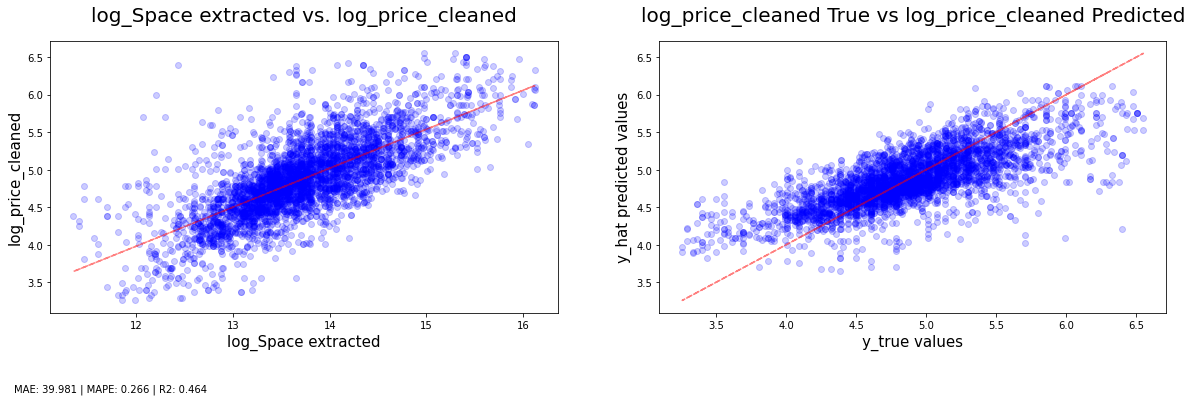

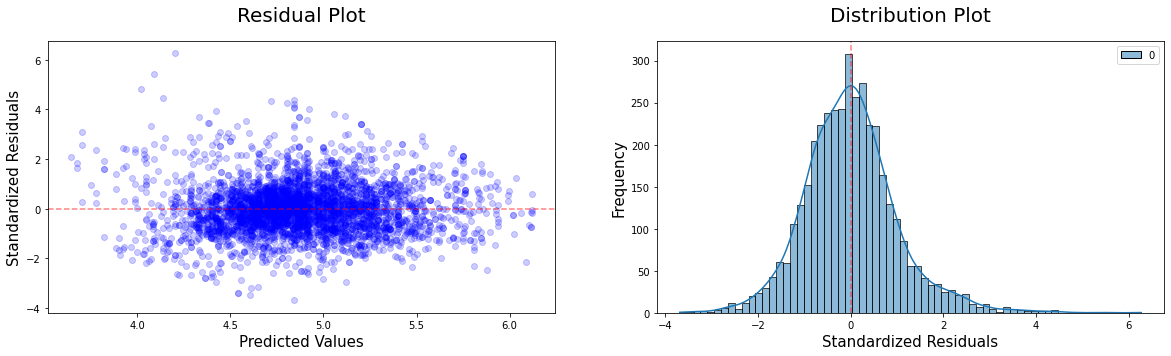

In [69]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted_outliers_removed, price_cleaned_outliers_removed, x_transform = "log", y_transform = "log")

## Modell 7.1 - Resultate und Interpretation

Ein Lineares Regressionsmodell mittels Log Transformation von space_extraced und price_cleaned sowie das entfernen von Ausreisser liefert uns folgende Ergebenisse:

- MAE   : 39.981
- MAPE  : 0.266
- R2    : 0.464

Durch das entfernen der Outliers konnten wir unsere Metriken deutlich verbessern. Der MAPE sowie MAE wurden deutlich kleiner. Der R^2 ist liecht angestiegen, blieb jedoch unter 0.5. 

Auch erkennen wir in den Residuenanalysen, dass die Residuen unabhaengig voneinander sind und eine Normalverteilung haben. Der Erwartungswert ist 0.

---